In [4]:
import numpy as np
import pandas as pd 

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

<center><h1 style="color:darkblue">VinBigData Chest X-ray Abnormalities Detection</h1></center>
<center><h1 style="color:brown">Automatically localize and classify thoracic abnormalities from chest radiographs</h1></center>
<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/24800/logos/header.png?t=2020-12-17-19-26-15">

# 1. About the Competition

팔이 부러지면 방사선 전문의가 뼈를 구하는 데 도움을줍니다. 이 의사들은 CT 및 PET 스캔, MRI, 물론 X-ray와 같은 영상 기술을 사용하여 의학적 상태를 진단하고 치료합니다. 그러나 이러한 다양한 의료 도구로 작업 할 때 발생하는 것처럼 방사선 전문의는 매일 많은 문제에 직면하고 있으며, 아마도 가장 어려운 문제는 흉부 방사선 사진일 것입니다. <span style = "color : orange"> 흉부 X-ray의 해석은 최고의 의사라도 의료 오진으로 이어질 수 있습니다</ span>. 컴퓨터 지원 감지 및 진단 시스템(CADe / CADx)은 대도시 병원의 의사에 대한 부담을 줄이고 농촌 지역의 진단 품질을 개선하는 데 도움이 될 것입니다.

기존의 흉부 X-ray 영상 해석 방법은 이를 소견 목록으로 분류합니다. *** 현재 이미지에는 설명 할 수 없는 결과를 초래하는 위치에 대한 사양(specification?)이 없습니다 *** 의사에게보다 의미있는 진단 지원을 제공하려면 <span style = "color : brown"> 흉부 X-ray 이미지의 결과를 localizing</span>하는 솔루션이 필요합니다.

이 대회에서 :
- **작업** : 흉부 방사선 사진에서 <span style = "color : blue"> 14 가지 유형의 흉부 이상 </span>을 자동으로 localize하고 분류합니다.
- **데이터 세트** : <span style = "color : blue"> 18,000 개의 스캔 </span> : <span style = "color : blue"> 15,000 개의 학습 이미지 </span>로 구성되며 <span style = "color : blue"> 3,000개의 테스트 이미지 </span>로 평가됩니다.

# 2. Data

# 2.1 Intro

이 대회에서 우리는 일반적인 흉부 폐 질환을 분류하고 중요한 결과를 localizing하고 있습니다. 이것은 **물체 감지 및 분류** 문제입니다.

> 각 테스트 이미지에 대해 모든 결과에 대한 바운딩박스와 클래스를 예측합니다. 결과가 없다고 예측하는 경우 "14 1 0 0 1 1"의 예측을 만들어야합니다 (14는 결과 없음에 대한 클래스 ID이며 1.0의 신뢰도로 1 픽셀 경계 상자를 제공함).

이미지는 DICOM 형식이므로 시각화 및 분류에 유용한 추가 데이터가 포함되어 있습니다.

# 2.2 Dataset information

데이터셋은 DICOM 형식의 18,000 개의 PA(posto-anterior; 전후방) CXR 스캔으로 구성되며, 환자의 개인 정보를 보호하기 위해 익명화되었습니다. 모든 이미지는 경험이 풍부한 방사선 전문의 패널에 의해 아래에 나열된 14 개의 중요한 방사선 촬영 결과에 대해 라벨이 지정되었습니다.

|class_id|class_name|
|---|---|
| 0 | 대동맥 확대 |
| 1 | 무기폐 |
| 2 | 석회화 |
| 3 | 심비대 |
| 4 | 통합 |
| 5 | ILD |
| 6 | 침투 |
| 7 | 폐 불투명도 |
| 8 | 결절 / 질량 |
| 9 | 기타 병변 |
| 10 | 흉막 삼출 |
| 11 | 흉막 비후 |
| 12 | 기흉 |
| 13 | 폐 섬유증 |
| 14 | 찾을 수 없음 |

(한글로 보니까 더 어려운데요..?)

> "결과 없음" 관찰(14)은 위의 모든 결과가 없음을 포착하기위한 것입니다.

***이 대회의 핵심 부분은 여러 방사선 전문의의 ground truth를 사용하는 것입니다. ***

# 3. EDA

In [6]:
import os
import gc
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as ptc

from functools import partial
import multiprocessing as mpc
from joblib import Parallel, delayed

import pydicom as pdc
from pydicom.pixel_data_handlers.util import apply_voi_lut

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [9]:
base_dir = '/home/user/projects/kg/21_vbd/'

train_dir = base_dir + "input/train"
test_dir = base_dir + "input/test"

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

train_df = pd.read_csv(base_dir + "input/train.csv")
sample_submission = pd.read_csv(base_dir + "input/sample_submission.csv")

# 3.1 Train.csv

클래스 및 바운딩박스를 포함하여 각 객체에 대해 하나의 행이있는 학습셋 메타 데이터입니다. 테스트 및 학습의 일부 이미지에는 여러 개체가 있습니다.

## Columns

- **image_id** - unique image identifier
- **class_name** - the name of the class of detected object (or "No finding")
- **class_id** - the ID of the class of detected object
- **rad_id** - the ID of the radiologist that made the observation
- **x_min** - minimum X coordinate of the object's bounding box
- **y_min** - minimum Y coordinate of the object's bounding box
- **x_max** - maximum X coordinate of the object's bounding box
- **y_max** - maximum Y coordinate of the object's bounding box

In [10]:
train_df

image_id          class_name  class_id rad_id  \
0      50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1      21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2      9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3      051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4      063319de25ce7edb9b1c6b8881290140          No finding        14    R10   
...                                 ...                 ...       ...    ...   
67909  936fd5cff1c058d39817a08f58b72cae          No finding        14     R1   
67910  ca7e72954550eeb610fe22bf0244b7fa          No finding        14     R1   
67911  aa17d5312a0fb4a2939436abca7f9579          No finding        14     R8   
67912  4b56bc6d22b192f075f13231419dfcc8        Cardiomegaly         3     R8   
67913  5e272e3adbdaafb07a7e84a9e62b1a4c          No finding        14    R16   

        x_min   y_min   x_max   y_max  
0         NaN     NaN     NaN     NaN  
1         NaN     NaN     NaN     NaN  
2       691.0  1375.0  1653.0  1831.0  
3      1264.0   743.0  1611.0  1019.0  
4         NaN     NaN     NaN     NaN  
...       ...     ...     ...     ...  
67909     NaN     NaN     NaN     NaN  
67910     NaN     NaN     NaN     NaN  
67911     NaN     NaN     NaN     NaN  
67912   771.0   979.0  1680.0  1311.0  
67913     NaN     NaN     NaN     NaN  

[67914 rows x 8 columns]

In [11]:
train_df.isna().sum().to_frame().rename(columns={0:"Nan_counts"}).style.background_gradient(cmap="cool")

In [12]:
train_df.nunique().to_frame().rename(columns={0:"Unique Values"}).style.background_gradient(cmap="plasma")

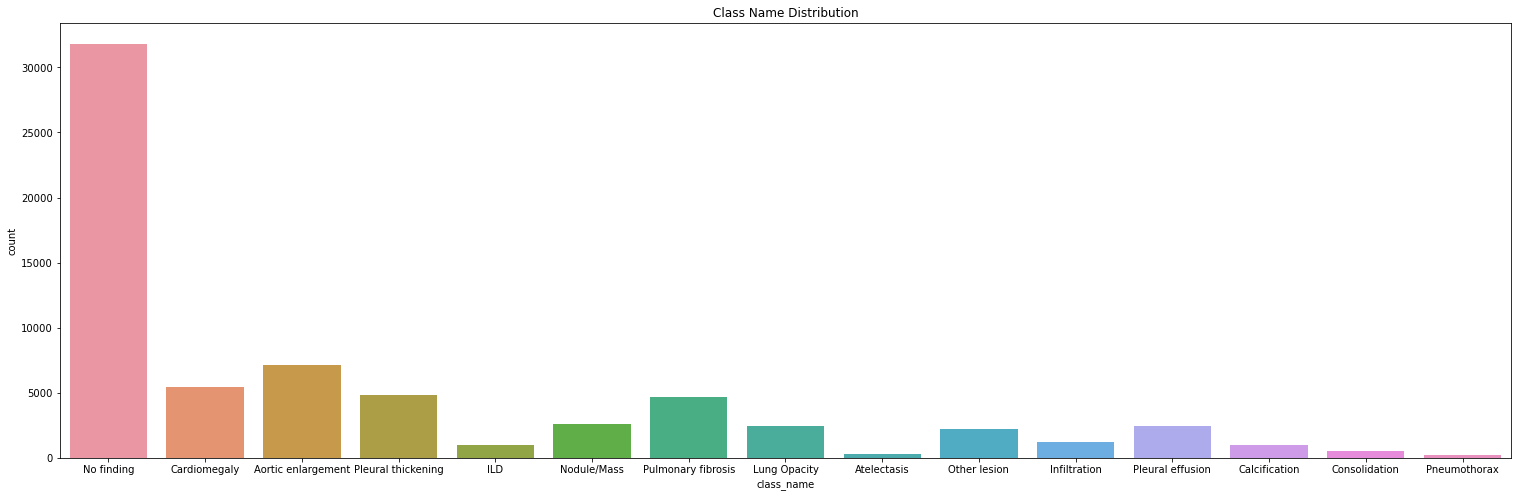

In [13]:
plt.figure(figsize=(26, 8))
sns.countplot(x="class_name", data=train_df)
plt.title("Class Name Distribution")
plt.show()

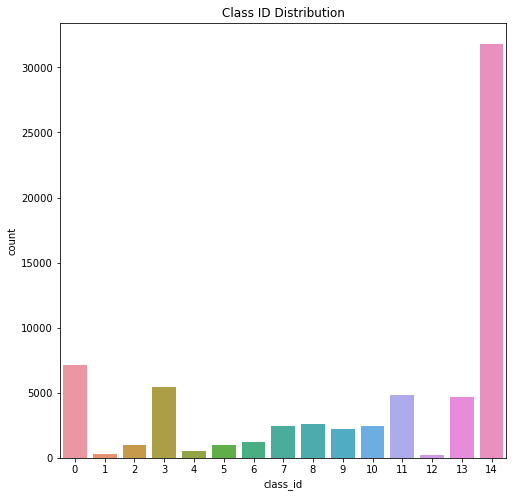

In [14]:
plt.figure(figsize=(8, 8))
sns.countplot(x="class_id", data=train_df)
plt.title("Class ID Distribution")
plt.show()

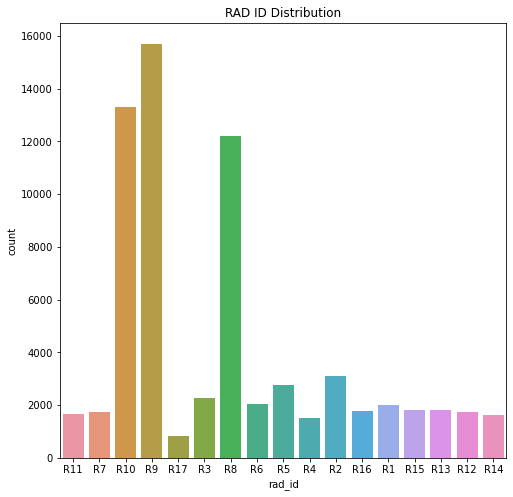

In [15]:
plt.figure(figsize=(8, 8))
sns.countplot(x="rad_id", data=train_df)
plt.title("RAD ID Distribution")
plt.show()

<Figure size 720x720 with 0 Axes>

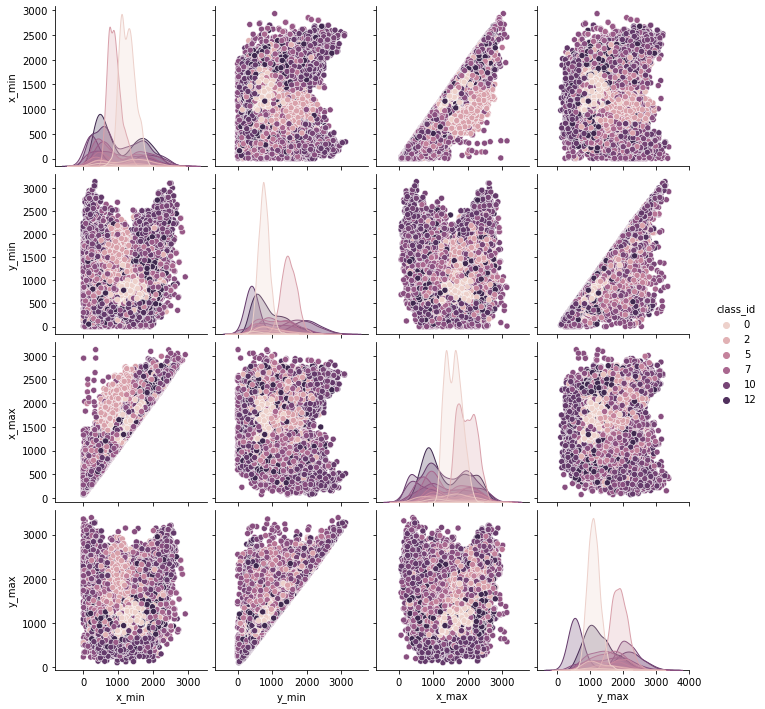

In [16]:
plt.figure(figsize=(10, 10))
sns.pairplot(train_df, hue='class_id')
plt.show()

In [ ]:
for i in range(14):
    plt.figure(figsize=(10, 10))
    sns.pairplot(train_df[train_df['class_id']==i], hue='class_id')
    plt.show()

* 14번 클래스를 빼고 보는 것도 필요할 듯!

# 4. DICOM Exploration

In [17]:
print("Number of train images: ", len(train_files))
print("Number of test images: ", len(test_files))

Number of train images:  15000
Number of test images:  3000


좋습니다. 설명한대로 학습셋 이미지는 **15000** 개, 테스트 용 이미지는 **3000** 개입니다. 그러나 train_df의 길이는 **67914**입니다. 그래서, 중복이 있어나 무엇 때문일까요?? train_df의 고유한 image_id를 확인합시다.

In [18]:
print("Unique images in train_df: ", train_df.image_id.nunique())

Unique images in train_df:  15000


따라서 학습 데이터셋에 하나 이상의 Ground Truth가 있음이 확인되었습니다. 이제 다음과 같이 살펴볼 것이 많습니다.
- 하나의 이미지에 bbox가 겹치지 않습니까?
- 다른 클래스는요? 그들은 다른 클래스에도 오버랩(over-lap)됩니까?
- 단일 이미지에서 클래스(또는 현재 대상)의 최대 수는 얼마입니까? 등

우리는 이러한 측면을 계속 탐구하고 몇 가지 통찰력을 얻으려고 노력할 것입니다. 하지만 먼저 DICOM에 대해 걱정합시다. train 및 test 폴더에서 이미지 파일 이름을 읽어 보겠습니다.

In [13]:
for _ in range(3):
    print(train_files[random.randint(0, len(train_files))])

4e7e82ca092514557584e8c9e234ee24.dicom
40d41571f7ee9a4583051e5ede025721.dicom
628ab07625d7ac80f9c909b4380e75b3.dicom


# 4.1. But What is [DICOM](https://en.wikipedia.org/wiki/DICOM)?

위키가 말하는 것은:

> DICOM (Digital Imaging and Communications in Medicine)은 의료 영상 정보 및 관련 데이터의 통신 및 관리를 위한 표준입니다. DICOM은 여러 제조업체의 스캐너, 서버, 워크 스테이션, 프린터, 네트워크 하드웨어 및 PACS (Picture Archiving and Communication System)와 같은 의료 영상 장치를 통합 할 수 있도록 의료 영상을 저장하고 전송하는 데 가장 일반적으로 사용됩니다. 병원에서 널리 채택되어 치과 의사 및 의사 사무실과 같은 소규모 응용 프로그램으로 진출하고 있습니다.

그리고 또?

-** DICOM 파일은 DICOM 형식으로 <span style = "color : red"> 이미지 </span> 및 <span style = "color : orange"> 환자 데이터 </span>를 수신 할 수있는 두 개체간에 교환할 수 있습니다.
    
- 다른 장치에는 지원하는 DICOM 클래스를 명시하는 DICOM 적합성 용법(?)이 함께 제공됩니다. 표준에는 파일 형식 정의와 TCP / IP를 사용하여 시스템간에 통신하는 네트워크 통신 프로토콜이 포함됩니다.

하나의 샘플을 읽고 갈아 봅시다.

In [14]:
sample_fn = train_df.image_id.to_list()[random.randint(0, len(train_df))]
sample = pdc.read_file(os.path.join(train_dir, sample_fn + ".dicom"))
sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 160
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 0ed4c066492aaa2e6f1772b84417e20f
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '069Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 3264
(0028, 0011) Columns                             US: 3196
(0028, 0

따라서 단일 환자의 경우 (예, Patients 및 image_ids에 일대일 매핑이 있으므로 토론 포럼의 주최자가 확인한대로 환자 당 중복되거나 두 개 이상의 이미지가 없습니다), 우리는 다음과 같은 엔티티를 가지고 있습니다.

- 환자의 성별
- 픽셀 당 샘플
- 광도 해석
- 행
- 열
- 픽셀 간격
- 할당 된 비트
- 저장된 비트
- 높은 비트
- 픽셀 표현
- 윈도우 센터
- 윈도우 너비
- Rescale Intercept
- 경사 재조정
- 손실 이미지 압축
- 픽셀 데이터

* 참고 : 다음 버전에서 직접 업데이트 할 때까지 댓글 섹션의 확장(extensions)에 대해 알려주세요. :) *

In [15]:
def read_dicom_df(fn):
    _ = pdc.read_file(os.path.join(train_dir, fn))
    pass

#_ = Parallel(-1, verbose=1)(delayed(read_dicom_df)(x) for x in train_files)

# 5. Images(Extension from Dicom)

Update 1: Ref: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way by @raddar

# 5.1 Visualising Images

In [16]:
def plot_pixel_array(data, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.show()


# ref kernel: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
def read_xray(path, voi_lut=True, fix_monochrome=True):
    dcm_data = pdc.read_file(path)
    
    def show_dcm_info(data):
        print("Gender :", data.PatientSex)
        if 'PixelData' in data:
            rows = int(data.Rows)
            cols = int(data.Columns)
            print("Image size : {rows:d} x {cols:d}, {size:d} bytes".format(
                rows=rows, cols=cols, size=len(data.PixelData)))
            if 'PixelSpacing' in data:
                print("Pixel spacing :", data.PixelSpacing)
    
    show_dcm_info(dcm_data)
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dcm_data.pixel_array, dcm_data)
    else:
        data = dcm_data.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dcm_data.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

Examining train images...
Gender : O
Image size : 2430 x 1994, 9690840 bytes
Pixel spacing : [0.175, 0.175]


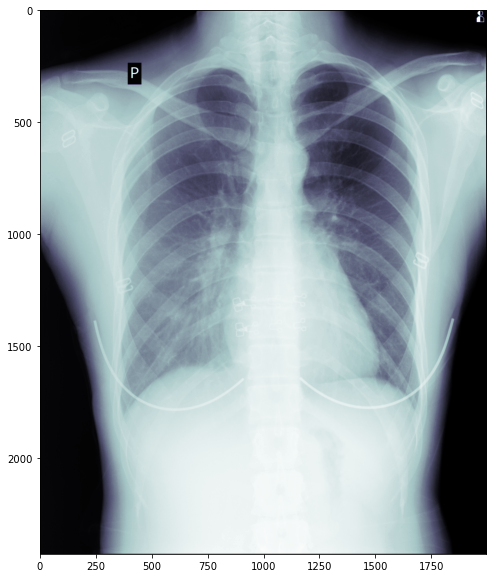

Gender : O
Image size : 2500 x 2048, 4727048 bytes
Pixel spacing : [0.168, 0.168]


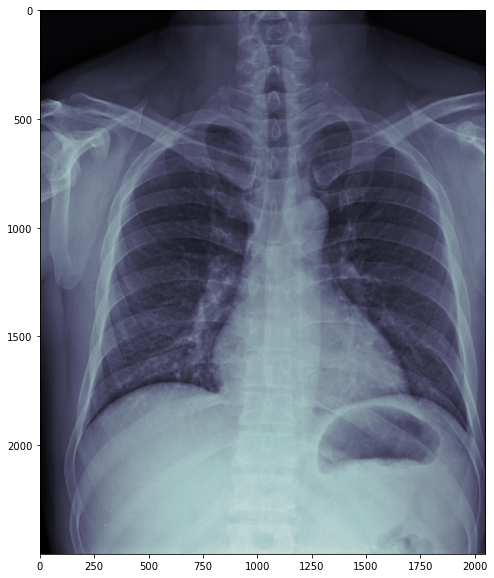

Gender : F
Image size : 3080 x 2384, 4728264 bytes
Pixel spacing : [0.127, 0.127]


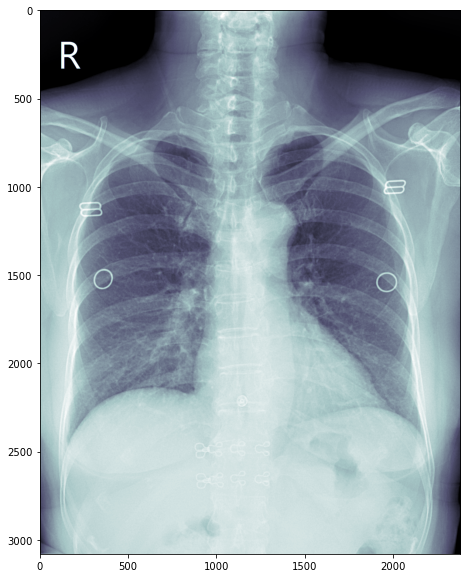

Gender : M
Image size : 2430 x 1994, 9690840 bytes
Pixel spacing : [0.175, 0.175]


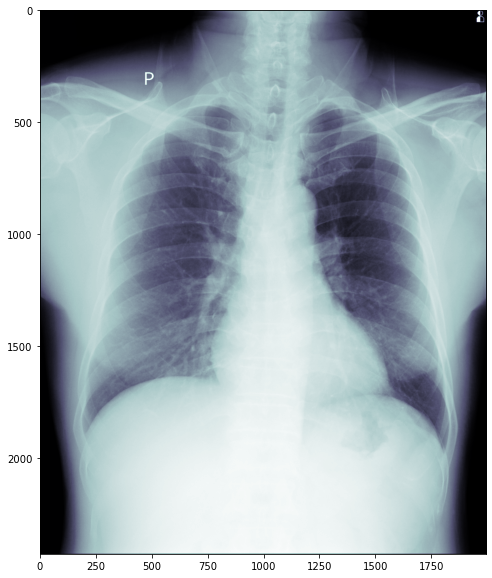

Gender : F
Image size : 3072 x 2540, 15605760 bytes
Pixel spacing : [0.140, 0.140]


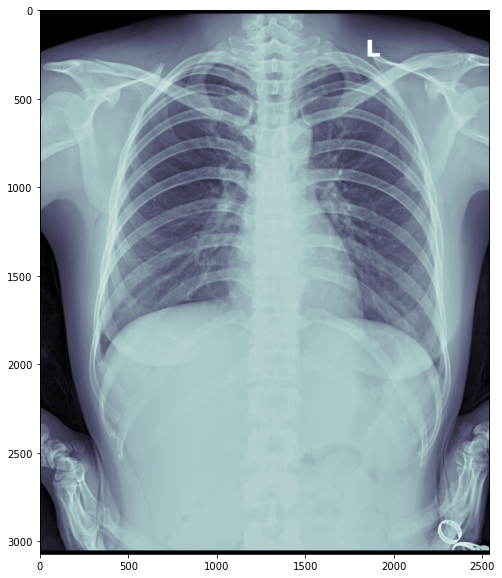

In [17]:
print("Examining train images...")
for _ in range(5):
    fn = train_files[np.random.randint(0, len(train_files))]
    file_path = os.path.join(train_dir, fn)
    data = read_xray(file_path)
    plot_pixel_array(data)

Examining test images...
Gender : F
Image size : 3072 x 2540, 15605760 bytes
Pixel spacing : [0.140, 0.140]


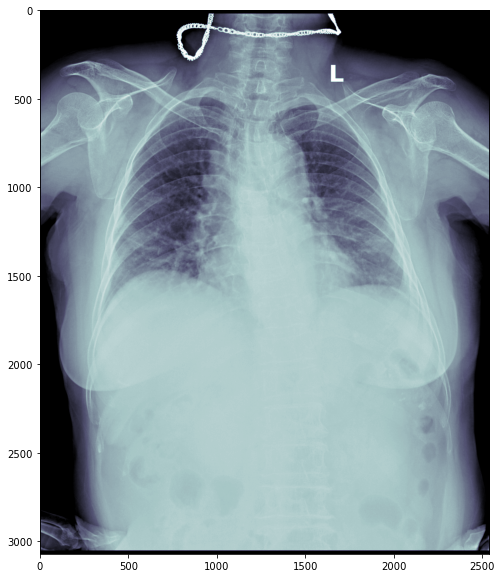

Gender : F
Image size : 2880 x 2304, 13271040 bytes
Pixel spacing : [0.15, 0.15]


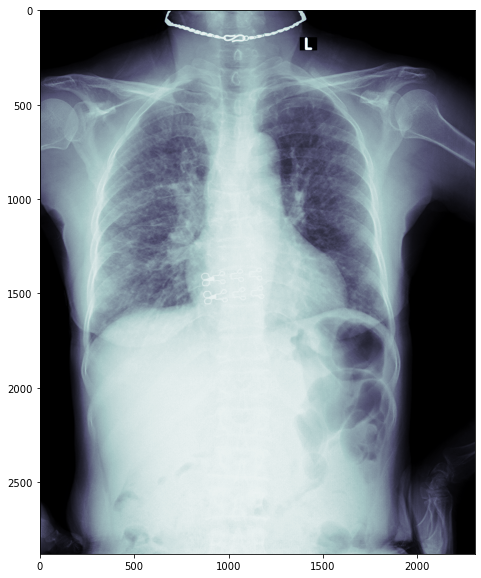

Gender : O
Image size : 2430 x 1994, 9690840 bytes
Pixel spacing : [0.175, 0.175]


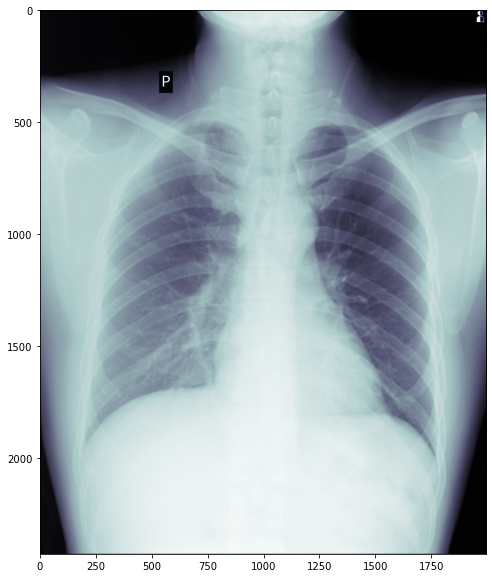

Gender : M
Image size : 2712 x 2401, 8311042 bytes
Pixel spacing : [0.141, 0.141]


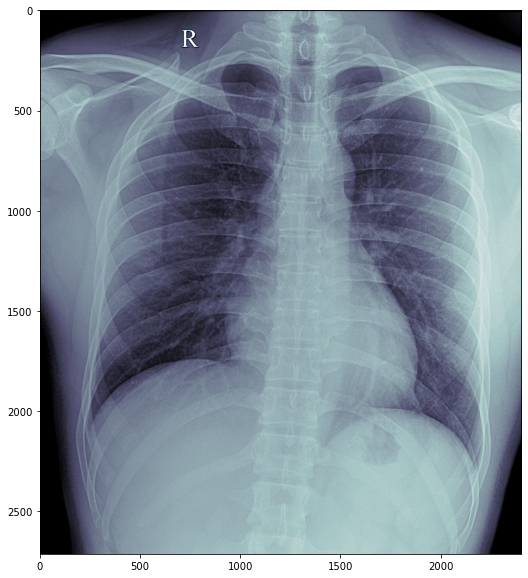

Gender : O
Image size : 2500 x 2048, 4847702 bytes
Pixel spacing : [0.168, 0.168]


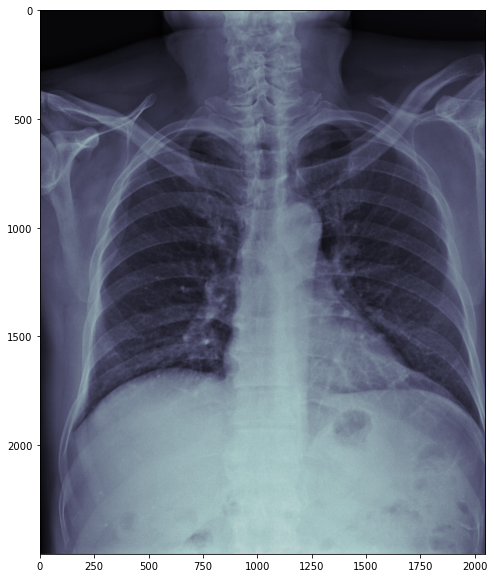

In [18]:
print("Examining test images...")
for _ in range(5):
    fn = test_files[np.random.randint(0, len(test_files))]
    file_path = os.path.join(test_dir, fn)
    data = read_xray(file_path)
    plot_pixel_array(data)

# 5.2 Examine the localizations

Gender : M
Image size : 3072 x 2540, 15605760 bytes
Pixel spacing : [0.140, 0.140]
Gender : M
Image size : 2790 x 2446, 8743740 bytes
Pixel spacing : [0.141, 0.141]
Gender : F
Image size : 3408 x 3064, 20884224 bytes
Gender : O
Image size : 2836 x 2336, 13249792 bytes
Pixel spacing : [0.15, 0.15]
Gender : O
Image size : 2500 x 2048, 4974458 bytes
Pixel spacing : [0.168, 0.168]
Gender : F
Image size : 3072 x 3072, 18874368 bytes
Pixel spacing : [0.140, 0.140]
Gender : O
Image size : 2880 x 2304, 13271040 bytes
Pixel spacing : [0.15, 0.15]
Gender : F
Image size : 3000 x 2997, 8419890 bytes
Gender : F
Image size : 2880 x 2304, 13271040 bytes
Pixel spacing : [0.15, 0.15]
Gender : M
Image size : 2880 x 2304, 6184330 bytes
Pixel spacing : [0.15, 0.15]


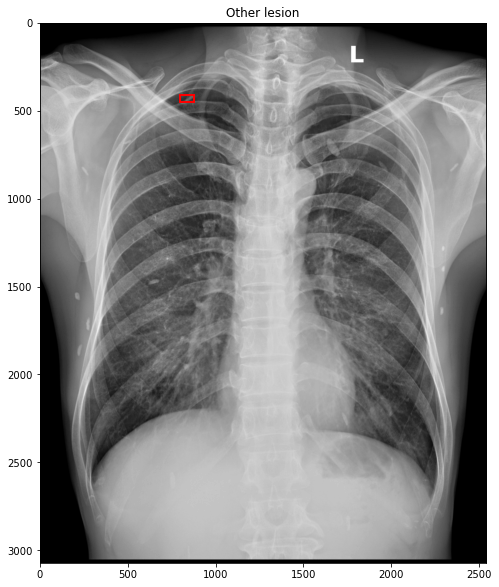

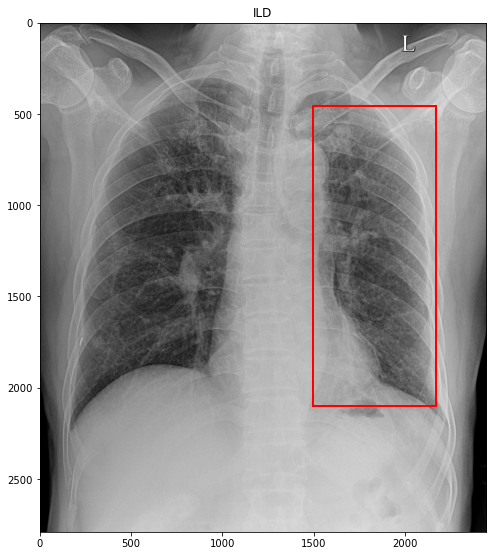

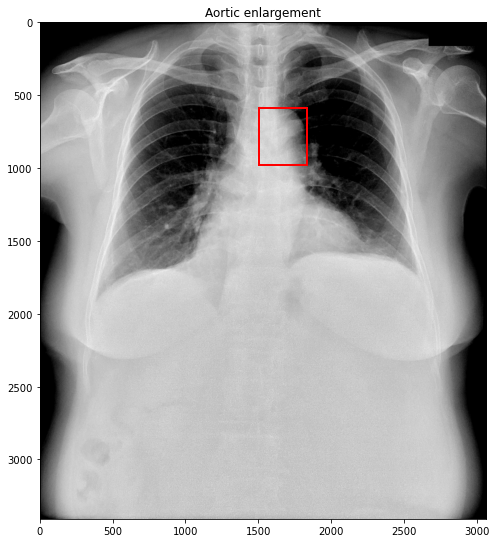

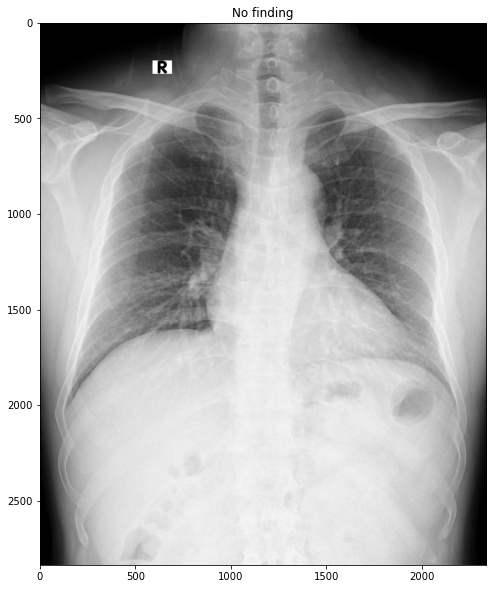

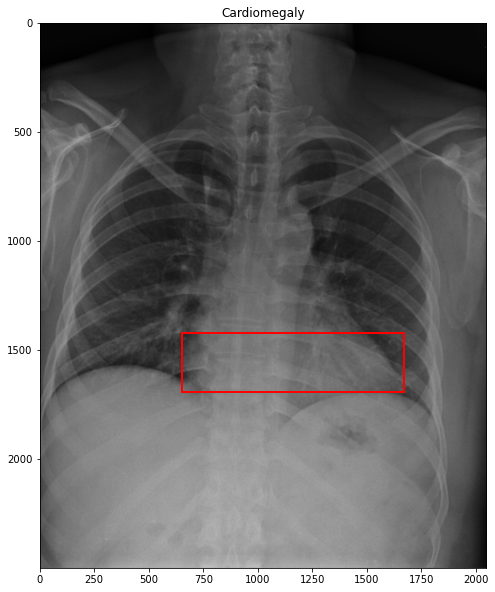

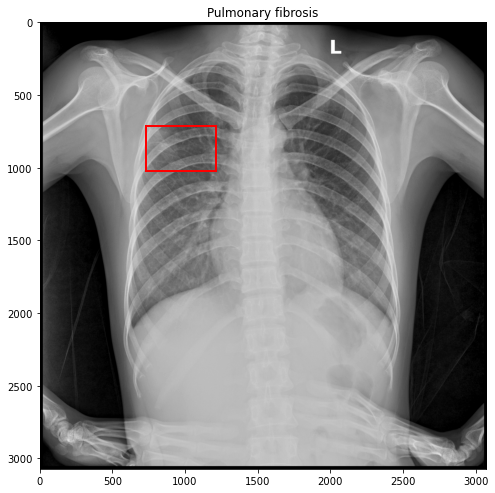

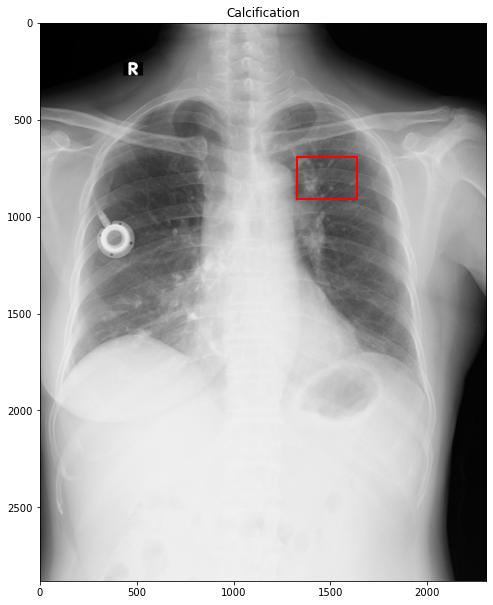

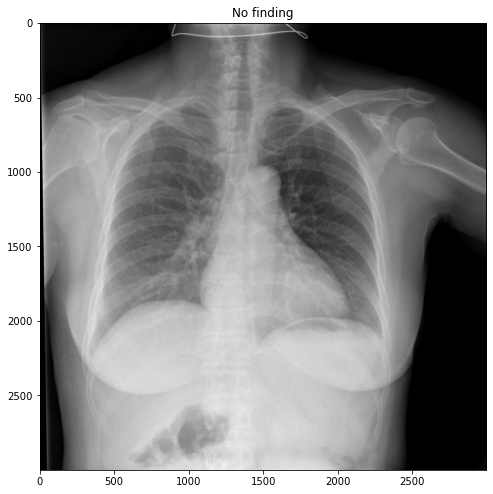

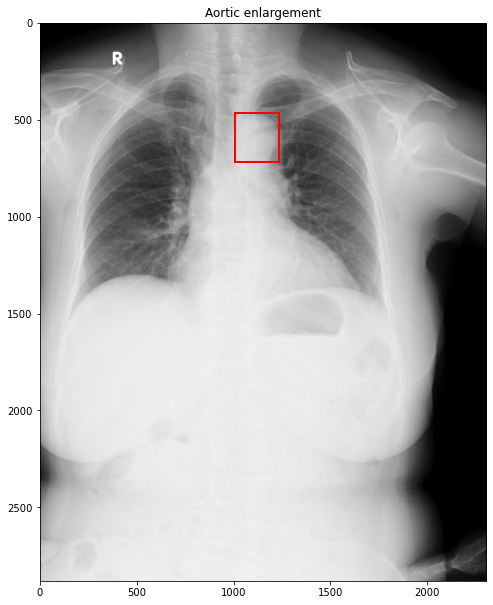

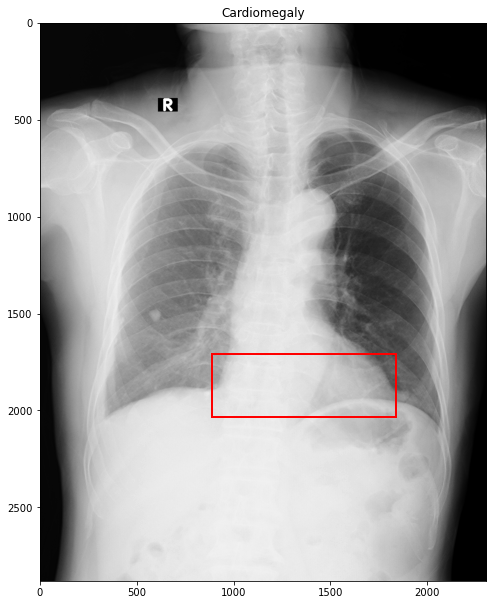

In [19]:
for _ in range(10):
    idx = np.random.randint(0, len(train_files))
    img_id = train_df.loc[idx, 'image_id']
    img = read_xray(os.path.join(train_dir, img_id+".dicom"))
    plt.figure(figsize=(8, 14))
    plt.imshow(img, cmap='gray')
    plt.title(train_df.loc[idx, 'class_name'])
    
    if train_df.loc[idx, 'class_name'] != 'No finding':
        bbox = [train_df.loc[idx, 'x_min'],
                train_df.loc[idx, 'y_min'],
                train_df.loc[idx, 'x_max'],
                train_df.loc[idx, 'y_max']]
        
        patch = ptc.Rectangle((bbox[0], bbox[1]),
                              bbox[2]-bbox[0],
                              bbox[3]-bbox[1],
                              ec='r', fc='none', lw=2.)
        ax = plt.gca()
        ax.add_patch(patch)

# 6. Sample Submission

In [20]:
sample_submission

image_id PredictionString
0     002a34c58c5b758217ed1f584ccbcfe9     14 1 0 0 1 1
1     004f33259ee4aef671c2b95d54e4be68     14 1 0 0 1 1
2     008bdde2af2462e86fd373a445d0f4cd     14 1 0 0 1 1
3     009bc039326338823ca3aa84381f17f1     14 1 0 0 1 1
4     00a2145de1886cb9eb88869c85d74080     14 1 0 0 1 1
...                                ...              ...
2995  ff91fb82429a27521bbec8569b041f02     14 1 0 0 1 1
2996  ff9fcc4087ed5e941209aa3fa948e364     14 1 0 0 1 1
2997  ffaa288c8abca300974f043b57d81521     14 1 0 0 1 1
2998  ffc441e0c8b7153844047483a577e7c3     14 1 0 0 1 1
2999  ffccf1709d0081d122a1d1f9edbefdf1     14 1 0 0 1 1

[3000 rows x 2 columns]

In [21]:
sample_submission.to_csv("submission.csv", index=False)

<h1 style="color:red">Work in Progress...</h1>
Thanks for reading till the end, consider upvoting the kernel, if you enjoyed reading it ;)